In [1]:
# %%capture
# !pip install transformers

In [2]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import time

/home/sdp/anaconda3/envs/bert_profile/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
datapath = f'bbc-text.csv'
df = pd.read_csv(datapath)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
# df.groupby(['category']).size().plot.bar()

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [6]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [7]:
def train(model, train_data, val_data, learning_rate, epochs, criterion, optimizer):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=32)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()
            
    duration = []
    duration_model = []
    t1 = time.time()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                t2 = time.time()
                output = model(input_id, mask)
                dur_model = time.time() - t2
                
                duration_model.append(dur_model)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            test_time = time.time() - t1
            
            duration.append(test_time)
            
#             with torch.no_grad():

#                 for val_input, val_label in val_dataloader:

#                     val_label = val_label.to(device)
#                     mask = val_input['attention_mask'].to(device)
#                     input_id = val_input['input_ids'].squeeze(1).to(device)

#                     output = model(input_id, mask)

#                     batch_loss = criterion(output, val_label.long())
#                     total_loss_val += batch_loss.item()
                    
#                     acc = (output.argmax(dim=1) == val_label).sum().item()
#                     total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
    
    return duration, np.average(duration_model)
                  

In [8]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        duration_inf = []
        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            t1 = time.time()
            output = model(input_id, mask)
            dur = time.time() - t1
            
            duration_inf.append(dur)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return np.average(duration_inf)

In [9]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [10]:
EPOCHS = 1
model_org = BertClassifier()
LR = 1e-6
              
model_org.train()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_org.parameters(), lr=LR)

duration, duration_model = train(model_org, df_train, df_val, LR, EPOCHS, criterion, optimizer)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [10:20<00:00, 11.09s/it]

Epochs: 1 | Train Loss:  0.051 | Train Accuracy:  0.238 | Val Loss:  0.000 | Val Accuracy:  0.000


In [11]:

model_org.eval()
duration_inf = evaluate(model_org, df_test)

Test Accuracy:  0.359


In [16]:
#with IPEX
import intel_extension_for_pytorch as ipex
model = BertClassifier()              
optimizer = Adam(model.parameters(), lr=LR)
model.train()
model_train, optimizer = ipex.optimize(model, optimizer=optimizer)
optimizer = Adam(model_train.parameters(), lr=LR)
duration_ipex, duration_model_ipex = train(model_train, df_train, df_val, LR, EPOCHS,criterion, optimizer)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [09:20<00:00, 10.01s/it]

Epochs: 1 | Train Loss:  0.051 | Train Accuracy:  0.220 | Val Loss:  0.000 | Val Accuracy:  0.000


In [17]:
#with IPEX
model.eval()
model_ipex = ipex.optimize(model_org)
duration_inf_ipex = evaluate(model_ipex, df_test)

/home/sdp/anaconda3/envs/bert_profile/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:396: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn("Conv BatchNorm folding failed during the optimize process.")
/home/sdp/anaconda3/envs/bert_profile/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:401: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn("Linear BatchNorm folding failed during the optimize process.")


Test Accuracy:  0.359


In [18]:
#with IPEX bfloat16
model.eval()
model_ipex_bf16 = ipex.optimize(model_org, dtype=torch.bfloat16)
duration_inf_ipex_bf16 = evaluate(model_ipex_bf16, df_test)

[W LegacyTypeDispatch.h:74] Warning: AutoNonVariableTypeMode is deprecated and will be removed in 1.10 release. For kernel implementations please use AutoDispatchBelowADInplaceOrView instead, If you are looking for a user facing API to enable running your inference-only workload, please use c10::InferenceMode. Using AutoDispatchBelowADInplaceOrView in user code is under risk of producing silent wrong result in some edge cases. See Note [AutoDispatchBelowAutograd] for more details. (function operator())


Test Accuracy:  0.359


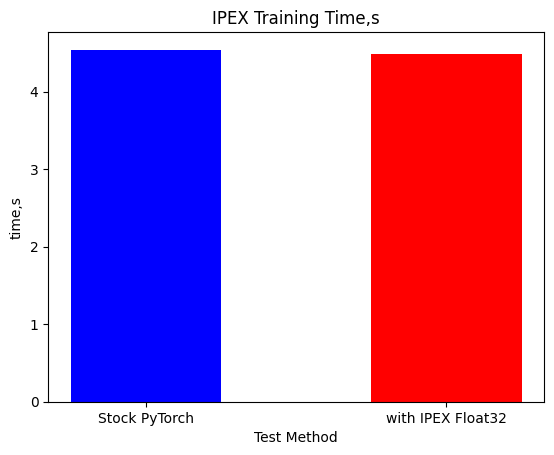

Performance Speedup Training model:  1.011338848497676


In [19]:
#show performanace boost: Training (of only model)
import matplotlib.pyplot as plt 

time_training_model = duration_model
time_training_model_ipex = duration_model_ipex

pred_times = [time_training_model, time_training_model_ipex]
tick_label = ['Stock PyTorch', 'with IPEX Float32']

left = [1,2]
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['blue', 'red'])
plt.xlabel('Test Method'); plt.ylabel('time,s'); plt.title('IPEX Training Time,s')
plt.show()
plt.close()

# print("Performance Speedup Training: ",(time_train)/(time_train_ipex))
print("Performance Speedup Training model: ",(time_training_model)/(time_training_model_ipex))

In [ ]:
# #show performanace boost: Training (epoch by epoch)
  
# X = ['Epoch1','Epoch2','Epoch3','Epoch4','Epoch5']
  
# X_axis = np.arange(len(X))
  
# plt.bar(X_axis - 0.2, duration, 0.4, label = 'Stock PyTorch')
# plt.bar(X_axis + 0.2, duration_ipex, 0.4, label = 'IPEX')
  
# plt.xticks(X_axis, X)
# plt.xlabel("Groups")
# plt.ylabel("Latency")
# plt.title("Epoch by Epoch comparison")
# plt.legend()
# plt.show()
# plt.close()

# # print("Performance Speedup Training: ",(time_train)/(time_train_ipex))
# print("Performance Speedup Training model: ",(np.average(duration))/(np.average(duration_ipex)))

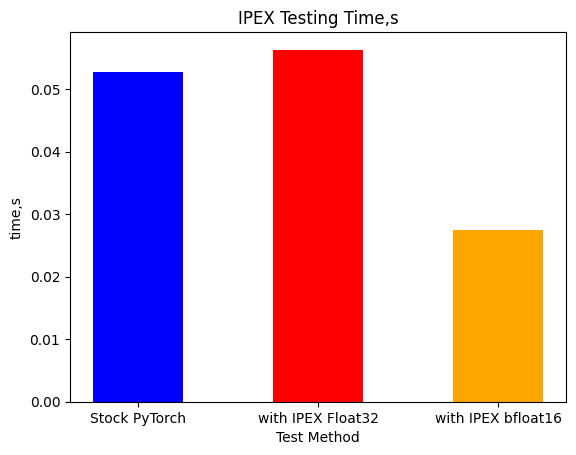

Performance Speedup testing model:  1.9155482079708461


In [20]:
#show performanace boost: Inference

time_training_model = duration_inf
time_training_model_ipex = duration_inf_ipex
time_training_model_ipex_bf16 = duration_inf_ipex_bf16

pred_times = [time_training_model, time_training_model_ipex, time_training_model_ipex_bf16]
tick_label = ['Stock PyTorch', 'with IPEX Float32', 'with IPEX bfloat16']

left = [1,2,3]
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['blue', 'red', 'orange'])
plt.xlabel('Test Method'); plt.ylabel('time,s'); plt.title('IPEX Testing Time,s')
plt.show()
plt.close()

# print("Performance Speedup Training: ",(time_train)/(time_train_ipex))
print("Performance Speedup testing model: ",(time_training_model)/(time_training_model_ipex_bf16))